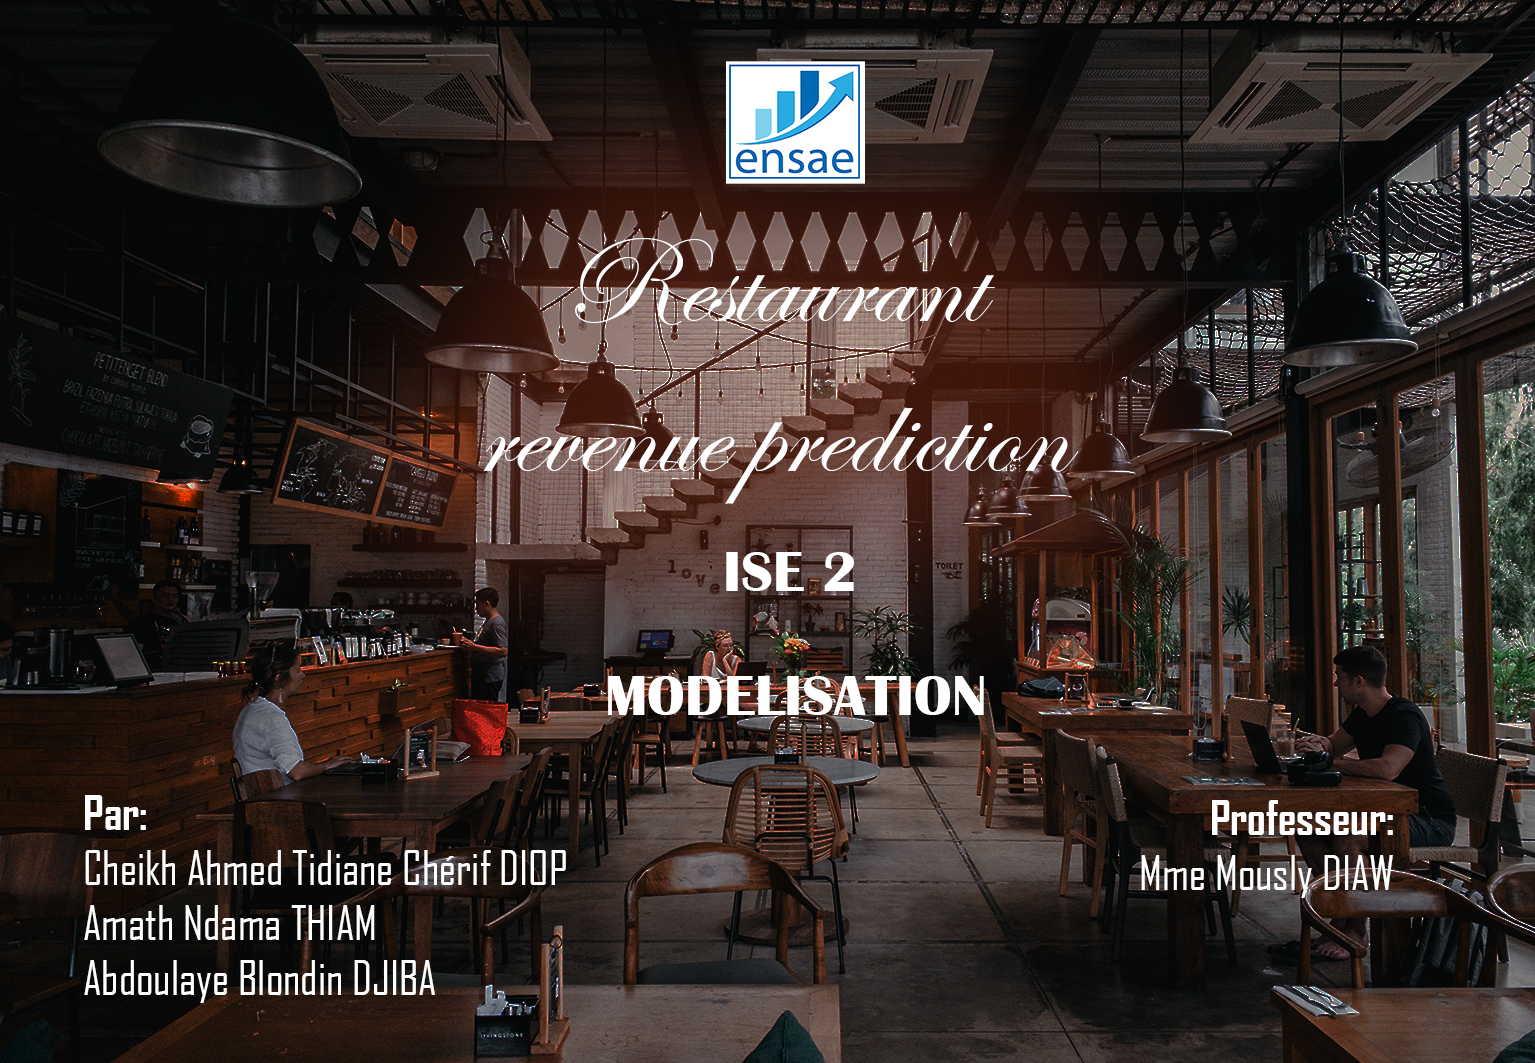

In [78]:
from IPython.display import Image
Image('image1.png')

In [79]:
from datetime import datetime,time,timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import profile_report 
import plotly.express as px
import scipy as sp
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import fetch_california_housing, fetch_openml, load_boston, load_diabetes
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder,FunctionTransformer
import datetime
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from abc import ABC
from collections.abc  import Mapping
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.svm import SVR
from math import sqrt
import pandoc


Chargement des données

In [80]:
training=pd.read_csv('C:/Users/Hp/Desktop/study/machine learning/projet ml/train.csv')
X_test=pd.read_csv('C:/Users/Hp/Desktop/study/machine learning/tp regression/ensae_project-master/courses/supervised_learning/test.csv')

Définition de la target et des variables explicatives

In [81]:
y=training['revenue']
X=training.drop('revenue',1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_6052\3678201789.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=training.drop('revenue',1)


In [82]:
log_y=np.log(y)

Formation de la pipeline pour le preprocessing
----------------------------------------------

In [83]:
def formatdate(base):
    format="%m/%d/%Y"
    for i in range(base.shape[0]):
        base['Open Date'][i]=datetime.datetime.strptime(base['Open Date'][i], format)
    #base['Open Date'] = pd.to_datetime(base['Open Date'], format='%m/%d/%Y')
    #base['Open Date'] = datetime.datetime.strptime(base['Open Date'], '%m/%d/%Y')   
    return base


In [84]:
def ageresto(base):
    for i in range(base.shape[0]):
        #base['Open Date'][i]=calculage(base['Open Date'][i])
        base['Open Date'][i]=(datetime.datetime.now() - base['Open Date'][i]).days // 365
    return base

In [85]:
def regroupement_villes(base):
    for i in range(base.shape[0]) :
        if  ((base['City'][i]!='İstanbul') and (base['City'][i]!='Ankara')):
            base['City'][i]='Autres_villes'
            
    return base
    

    
def retirer_id(base):
    base=base.drop('Id',1)
    return base

In [86]:
def datenumeric(base):
    base["Open Date"]=pd.to_numeric(base["Open Date"])
    return base

In [87]:
def normalisation_standardisation(base):
    numerical_features = base.select_dtypes(include="number").columns
    scaler=StandardScaler()
    #norm=MinMaxScaler()
    #norm.fit(base[numerical_features])
    scaler.fit(base[numerical_features])
    #base[numerical_features] = norm.transform(base[numerical_features])
    base[numerical_features] = scaler.transform(base[numerical_features])
    return base

In [88]:
#Cette methode ne sera pas utilisée dans la suite car elle fait des
#variables selectionnées des variables ordinales
def encodage(base):
    codes= { 'İstanbul':1,
             'Ankara':2,
             'Autres_villes':3,
             'Big Cities':1,
             'Other':0,
             'FC':1,
             'IL':2,
             'DT':3,
             'MB':4}
    for j in base.select_dtypes('object').columns:
        base.loc[:,j]=base[j].map(codes)
    return base


Nous utiliserons alors plutôt le Onehotencoding

Seulement l'un des problèmes avec OneHotENcoder est qu'il transforme
chaque modalité en variable.
or nous avons une modalité qui figure dans la base test et non dans la
base train. De ce fait, vu que les modéles seront entrainés sur la base
train, il y aura des erreurs vu que la base test après preprocessing
devra avoir le même nombre de features que la base train. 
Donc après la transformation de X_train nous ajouterons une colonne pour la 
modalité restante 

In [89]:
categories=['City','City Group','Type']

def encodageOne(base):
    
    encode=OneHotEncoder()
    categorie_a_encoder=base[categories]
    encode2=encode.fit_transform(categorie_a_encoder)
    encode2_colonnes = encode.get_feature_names(categories)
    categories_a_ajouter=pd.DataFrame(encode2.toarray(), columns=encode2_colonnes)
    new_base=pd.concat([base,categories_a_ajouter],axis=1)
    new_base=new_base.drop(['City','City Group','Type'],1)
    
    return new_base
    

In [90]:
standnorm=FunctionTransformer(normalisation_standardisation)

dateform=FunctionTransformer(formatdate)

age=FunctionTransformer(ageresto)

numericdate=FunctionTransformer(datenumeric)

villes=FunctionTransformer(regroupement_villes)

encode=FunctionTransformer(encodageOne)

id_retrait=FunctionTransformer(retirer_id)



In [91]:
preprocessing=Pipeline(steps=[
                              ('retirer Id',id_retrait),
                      ('changer le format en date',dateform),
                     ('calculer age des restos',age),
                     ('transformer age en format numerique',numericdate),
                     ('standardisation et normalisation',standnorm),
                     ('regrouper certaines villes',villes),
                     ('encoder les variables categorielles',encode)])

In [92]:
etapes_prep = pd.DataFrame(preprocessing.steps, columns=['Noms','Fonctions'])
etapes_prep

,Noms,Fonctions
0,retirer Id,FunctionTransformer(func=<function retirer_id ...
1,changer le format en date,FunctionTransformer(func=<function formatdate ...
2,calculer age des restos,FunctionTransformer(func=<function ageresto at...
3,transformer age en format numerique,FunctionTransformer(func=<function datenumeric...
4,standardisation et normalisation,FunctionTransformer(func=<function normalisati...
5,regrouper certaines villes,FunctionTransformer(func=<function regroupemen...
6,encoder les variables categorielles,FunctionTransformer(func=<function encodageOne...


Transformation de la matrice X
----------------------

In [93]:
X_train=preprocessing.fit_transform(X)
X_train=pd.DataFrame(X_train)

C:\Users\Hp\AppData\Local\Temp\ipykernel_6052\3811426361.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  base=base.drop('Id',1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6052\3783768985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['Open Date'][i]=datetime.datetime.strptime(base['Open Date'][i], format)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6052\3811426361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['City'][i]='Autres_villes'
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: Futu

In [94]:
#AJout de la colonne pour Mb
MB=pd.DataFrame(0,columns=["Type_MB"],index=range(137))
X_train=pd.concat([X_train,MB],axis=1)

In [95]:
X_train

,Open Date,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P37,City_Ankara,City_Autres_villes,City_İstanbul,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL,Type_MB
0,2.389353,-0.005034,0.391716,-0.308701,-0.367578,-0.006056,-0.638471,-0.185001,-0.622801,-0.243564,...,1.615951,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0
1,0.157480,-0.005034,0.391716,-0.308701,-0.367578,-0.835796,-0.638471,-0.185001,-0.082777,-0.243564,...,-0.625925,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
2,-1.082449,-0.694749,-0.270816,-2.253162,0.619837,-0.006056,-0.168199,-0.185001,-0.082777,-0.243564,...,-0.625925,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,-0.834463,0.684680,0.060450,1.635760,1.607252,1.653422,0.302072,1.999921,1.537293,2.491539,...,2.736889,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,-0.090506,-0.349892,-0.270816,-1.280931,-0.367578,-0.006056,-0.638471,-0.185001,-0.082777,-0.243564,...,1.055482,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,0.157480,-0.694749,-0.933348,-1.280931,0.619837,1.653422,-0.638471,-0.621985,-0.622801,-0.790585,...,-0.625925,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
133,0.653452,-0.005034,0.391716,-0.308701,-0.367578,-0.006056,-0.168199,-0.185001,-0.622801,-0.790585,...,-0.625925,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
134,0.653452,-0.349892,-0.270816,-0.308701,-0.367578,-0.006056,-0.168199,-0.185001,-0.082777,-0.243564,...,-0.625925,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
135,-0.338492,-0.005034,0.391716,-0.308701,0.619837,-0.006056,-0.638471,-0.185001,-0.082777,-0.243564,...,-0.625925,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0


Représentation de l'histogramme des variables et de la densité de leur loi

In [96]:
liste_variables = list(X_train.select_dtypes(exclude=['object']).columns)

le message d'erreur est du à la colonne ajoutée qui ne contient que 
des 0

MODELISATION
--------------

Définition des différents modèles et entrainement sur le nouveau X

In [97]:
regression=LinearRegression()
decision=DecisionTreeRegressor()
ridge=Ridge()
rand=RandomForestRegressor()
lasso=Lasso(alpha=0.1)
svr=SVR(kernel='linear',C=1,epsilon=0.001)

In [98]:
regression.fit(X_train,log_y)
decision.fit(X_train,log_y)
ridge.fit(X_train,log_y)
rand.fit(X_train,log_y)
lasso.fit(X_train,log_y)
svr.fit(X_train,log_y)

SVR(C=1, epsilon=0.001, kernel='linear')

Affichage des métriques pour évaluer les modéles suivants:
Régression linéaire
-
Arbre décisionnel
-
Ridge
-
Random forest
-
Lasso
-
SVR regressor

In [99]:
#définissons d'abord le root mean squared error

def rmse(real_value, estimated_value):
    y=mean_squared_error(real_value, estimated_value)
    z=sqrt(y)
    return z

#choix des métriques
METRICS = [r2_score,
           mean_squared_error,
           rmse,
           mean_absolute_percentage_error,
           max_error,
          ]

def get_performances(real_value, estimated_value, metrics):
    perfs = []
    for metric_func in metrics:
        perfs.append((metric_func.__name__, metric_func(real_value, estimated_value)))
    return pd.DataFrame(perfs, columns=["metric", "value"])

liste_modeles=[regression,decision,ridge,rand,lasso,svr]


for model in liste_modeles :
    print('metriques du modele suivant:',model)
    model.fit(X_train,log_y)
    log_y_train_predit=model.predict(X_train)
    r=get_performances(real_value=log_y, estimated_value=log_y_train_predit, metrics=METRICS)
    print(r)

metriques du modele suivant: LinearRegression()
                           metric     value
0                        r2_score  0.457294
1              mean_squared_error  0.124493
2                            rmse  0.352836
3  mean_absolute_percentage_error  0.018300
4                       max_error  1.117820
metriques du modele suivant: DecisionTreeRegressor()
                           metric  value
0                        r2_score    1.0
1              mean_squared_error    0.0
2                            rmse    0.0
3  mean_absolute_percentage_error    0.0
4                       max_error    0.0
metriques du modele suivant: Ridge()
                           metric     value
0                        r2_score  0.449890
1              mean_squared_error  0.126192
2                            rmse  0.355235
3  mean_absolute_percentage_error  0.018575
4                       max_error  1.104254
metriques du modele suivant: RandomForestRegressor()
                           metric  

----------------------------------
Nous voyons que les modèles ne sont pas suffisamment efficaces
nous allons ainsi tester la cross validation et la recherche des
meilleurs hyperparamétres sur les modéles d'arbre décisionnel et
de fôret aléatoire puisqu'ils présentent les meilleurs résultats

Cross validation
-------------

In [39]:
cv_results = cross_validate(rand,
                            X_train, log_y,
                            cv=10,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
pd.DataFrame(cv_results)

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.198564,0.008522,0.575020,0.887658,-0.063177,-0.026760
1,0.167917,0.008523,0.237051,0.889570,-0.377782,-0.021975
2,0.163435,0.008523,-0.017474,0.892205,-0.099812,-0.026241
3,0.163936,0.008523,0.371704,0.890600,-0.134800,-0.025115
4,0.164491,0.008526,-0.173939,0.895578,-0.137050,-0.024273
5,0.175426,0.010027,0.323357,0.889790,-0.154551,-0.025144
6,0.216576,0.012533,0.396709,0.889930,-0.164403,-0.024668
7,0.184993,0.009526,0.265185,0.892702,-0.170497,-0.024505
8,0.167946,0.009025,-0.692422,0.904293,-0.275637,-0.022515
9,0.175464,0.009024,0.223662,0.893813,-0.130754,-0.024788


In [40]:
cv_results1 = cross_validate(decision,
                            X_train, log_y,
                            cv=10,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
pd.DataFrame(cv_results1)

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.005515,0.002007,0.444645,1.0,-0.082558,-0.0
1,0.003006,0.002008,0.196387,1.0,-0.397917,-0.0
2,0.003005,0.002008,-1.947527,1.0,-0.289148,-0.0
3,0.003508,0.002007,-0.224216,1.0,-0.262654,-0.0
4,0.002996,0.002506,-2.180221,1.0,-0.371271,-0.0
5,0.007053,0.003004,-0.818435,1.0,-0.415346,-0.0
6,0.005024,0.001996,-0.162463,1.0,-0.316783,-0.0
7,0.003007,0.001505,0.192341,1.0,-0.187399,-0.0
8,0.003509,0.002006,-1.793003,1.0,-0.454884,-0.0
9,0.002506,0.001504,-0.717389,1.0,-0.289250,-0.0


Affichage de la moyenne des résultats du cross validation

In [41]:
#d'abord pour le random forest
pd.DataFrame(np.mean(pd.DataFrame(cv_results)))

C:\Users\Hp\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,0
fit_time,0.177875
score_time,0.009275
test_r2,0.150885
train_r2,0.892614
test_neg_mean_squared_error,-0.170846
train_neg_mean_squared_error,-0.024598


In [49]:
# Maintenant pour le decision tree
pd.DataFrame(np.mean(pd.DataFrame(cv_results1)))

C:\Users\Hp\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,0
fit_time,0.003913
score_time,0.002055
test_r2,-0.700988
train_r2,1.000000
test_neg_mean_squared_error,-0.306721
train_neg_mean_squared_error,0.000000


Nous pouvons voir ainsi qu'avec la méthode du cross validation
le modéle d'arbre décisionnnel est parfait pour l'entrainement
mais très inefficace pour les données test 
Pareil pour le random forest mais qui lui présente quand même
des résultats plus acceptables. 

AInsi nous laisserons tomber le decision tree et nous nous concentrerons
sur la recherche des meilleurs hyperparametres pour le random forest

HYPERPARAMETRES
-----------

In [42]:
param_grid = {'n_estimators':[200,400,600,800,1000],
              'max_features':['auto','sqrt'],
              'max_depth':[10,20,30,40,50,60,70,80,90,100,None],
                           'bootstrap':[True,False]}

grid_search = GridSearchCV(rand, param_grid, cv=10, scoring="r2", return_train_score=True) # r2
# you can see the list of key for scoring: sorted(sklearn.metrics.SCORERS.keys())
grid_search

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [200, 400, 600, 800, 1000]},
             return_train_score=True, scoring='r2')

In [43]:
grid_search.fit(X_train, log_y)

best_params = grid_search.best_params_
print(f"Best params: {best_params}")

Best params: {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 200}


In [44]:
rand.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [45]:
grid_cv_results = grid_search.cv_results_
for group in ["train", "test"]:
    mean_score = round(100 * grid_cv_results[f'mean_{group}_score'].mean(), 2)
    mean_std_score = round(grid_cv_results[f'std_{group}_score'].mean(), 2)
    print(f"{group}====================\nMean score (std): {mean_score} ({mean_std_score})\n")

train====================
Mean score (std): 94.62 (0.0)

test====================
Mean score (std): -2.21 (0.41)



In [46]:
cv_results = pd.DataFrame(grid_cv_results)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[["mean_train_score", "std_train_score",
            "mean_test_score", "std_test_score",
            "mean_fit_time", "std_fit_time",
            "mean_score_time", "std_score_time"
           ]]

,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
20,0.895684,0.003398,0.175166,0.295516,0.320718,0.002527,0.014488,0.000270
21,0.898582,0.004140,0.174799,0.330116,0.643766,0.005158,0.027845,0.001460
102,0.897857,0.004229,0.172239,0.306339,0.976961,0.012179,0.039553,0.000351
11,0.896616,0.003077,0.171246,0.305810,0.641655,0.005516,0.027544,0.001297
1,0.892556,0.004910,0.171131,0.303117,0.623474,0.003036,0.024532,0.004458
...,...,...,...,...,...,...,...,...
111,0.965650,0.019937,-0.446853,0.743445,0.656664,0.011230,0.026821,0.000463
110,0.965650,0.019937,-0.448946,0.737244,0.329936,0.005669,0.014188,0.000231
114,0.965650,0.019937,-0.449077,0.745513,1.734112,0.178601,0.064844,0.002038
112,0.965650,0.019937,-0.450768,0.751366,0.981868,0.016783,0.039459,0.000936


On peut voir qu'il y a une amélioration des r2 sur les données
train mais toujours un faible r2 sur les données d'entrainement 

Nous avons clairement un overfitting dû à la taille insuffisante de 
la base

PREDICTIONS
-------------

Malgré l'overfitting nous utiliserons le modèle le moins inefficace
afin de prédire les revenus des restos

In [53]:
X_test=preprocessing.fit_transform(X_test)

C:\Users\Hp\AppData\Local\Temp\ipykernel_6052\3811426361.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  base=base.drop('Id',1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6052\3783768985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['Open Date'][i]=datetime.datetime.strptime(base['Open Date'][i], format)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6052\3811426361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['City'][i]='Autres_villes'
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: Futu

In [74]:
rand_pred=RandomForestRegressor(bootstrap=True, max_depth=30, n_estimators=200)

In [75]:
rand_pred.fit(X_train,log_y)

RandomForestRegressor(max_depth=30, n_estimators=200)

In [76]:
rand_pred.predict(X_test)

array([15.16623548, 15.02538642, 14.94400261, ..., 15.20391686,
       15.07646841, 15.50034263])

In [77]:
pd.DataFrame(np.exp(rand.predict(X_test)))

,0
0,3.674238e+06
1,3.220036e+06
2,3.552061e+06
3,3.654225e+06
4,4.094738e+06
...,...
99995,5.000224e+06
99996,2.687986e+06
99997,3.991520e+06
99998,3.495920e+06
